In [1]:
import pandas as pd
import operator as op
import seaborn as sns
import matplotlib.pyplot as plt

### Формирование датасета

In [53]:
customers = pd.read_csv("customers.csv")
orders = pd.read_csv("orders.csv")

In [54]:
df = pd.merge(orders, customers, 'inner', on='customer_id')

In [55]:
df['order_date'] = pd.to_datetime(df['order_date'])

### Необходимые функции

In [56]:
def get_cohorts(df, period='M'): 
    df = df[['customer_id','id','order_date']].drop_duplicates()
    df = df.assign(acquisition_cohort = df.groupby('customer_id')\
                   ['order_date'].transform('min').dt.to_period(period))
    df = df.assign(order_cohort = df['order_date'].dt.to_period(period))
    return df

In [57]:
def get_retention(df, period='M'):
    df = get_cohorts(df, period).groupby(['acquisition_cohort', 'order_cohort'])\
                                .agg(customers=('customer_id', 'count')) \
                                .reset_index(drop=False)
    df['periods'] = (df.order_cohort - df.acquisition_cohort)\
    .apply(op.attrgetter('n'))

    return df

In [58]:
def get_cohort_matrix(df, period='M', percentage=False):
    df = get_retention(df, period).pivot_table(index = 'acquisition_cohort',
                                               columns = 'periods',
                                               values = 'customers')
    if percentage:
        df = df.divide(df.iloc[:,0], axis=0)*100
    
    return df

In [64]:
def get_retention_2(df, period='M'):
    df = get_cohorts(df, period).groupby(['acquisition_cohort', 'order_cohort'])\
                                .agg(customers=('customer_id', 'nunique')) \
                                .reset_index(drop=False)
    df['periods'] = (df.order_cohort - df.acquisition_cohort)\
    .apply(op.attrgetter('n'))

    return df

In [65]:
def get_cohort_matrix_2(df, period='M', percentage=False):
    df = get_retention_2(df, period).pivot_table(index = 'acquisition_cohort',
                                               columns = 'periods',
                                               values = 'customers')
    if percentage:
        df = df.divide(df.iloc[:,0], axis=0)*100
    
    return df

### Общая картина по клиентам

In [59]:
df_matrix_y = get_cohort_matrix(df, 'Y', percentage=True)

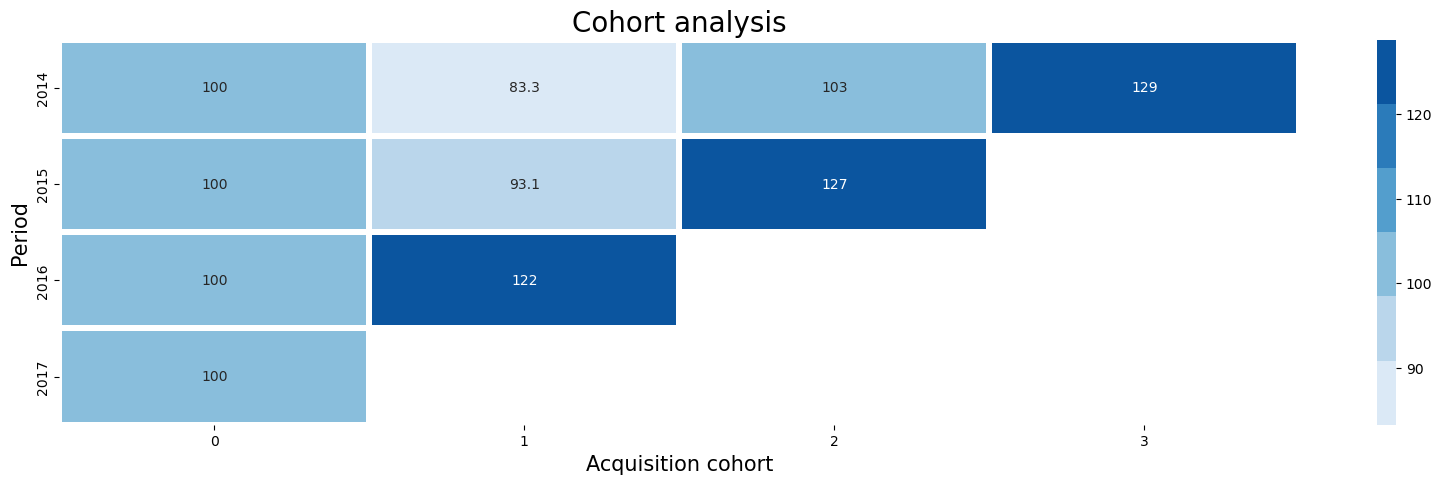

In [60]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

Получился тот же результат, что и в файле, хоть и подход по постороению когорт был изменен. В чем же дело? Дело в том, что мы считаем количество сделок пользователями и такое вполне возможно, что один и тот же пользователь генерит больше сделок в отчетном периоде. Давайте посмотрим на уникальных пользователей!

### Общая картина. Уникальные пользователи

In [67]:
df_matrix_y_2 = get_cohort_matrix_2(df, 'Y', percentage=True)

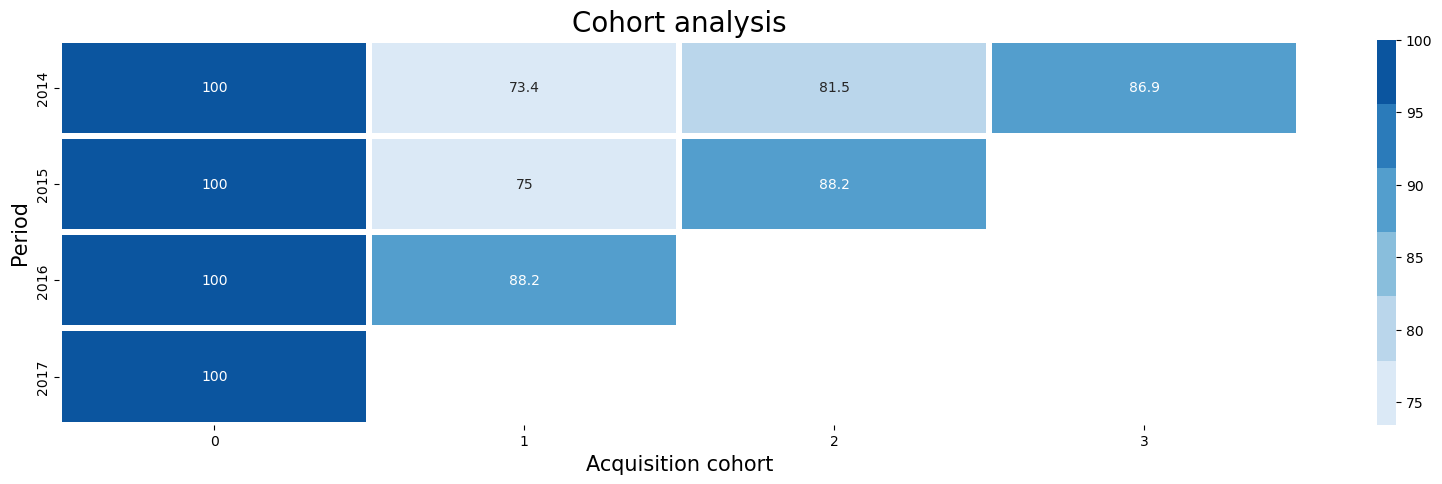

In [68]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_2, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

Вот что получается! Все числа меньше 100, поскольку число уникальных пользователей не может увеличиться в когортах. При этом, в 2016 и 2015 году наш retention rate получается одинаковым) Давайте предположим, что нашего руководитея страх как волнует retention уникальных пользователей, ему важно, чтобы пользователи оставались независимо от того, сколько они генерируют заказов или тратят (звучит, возможно, не очень логично, но для количества пользователей и денежного эквивалента задача решена в файлике solution, хочется посмотреть чего-то нового)

### Уникальные пользователи по сегментам

In [71]:
df_consumer = df.loc[df['segment'] == 'Consumer']

In [72]:
df_home = df.loc[df['segment'] == 'Home Office']

In [73]:
df_corporate = df.loc[df['segment'] == 'Corporate']

In [74]:
df_matrix_y_consumer = get_cohort_matrix_2(df_consumer, 'Y', percentage=True)

In [75]:
df_matrix_y_home = get_cohort_matrix_2(df_home, 'Y', percentage=True)

In [76]:
df_matrix_y_corporate = get_cohort_matrix_2(df_corporate, 'Y', percentage=True)

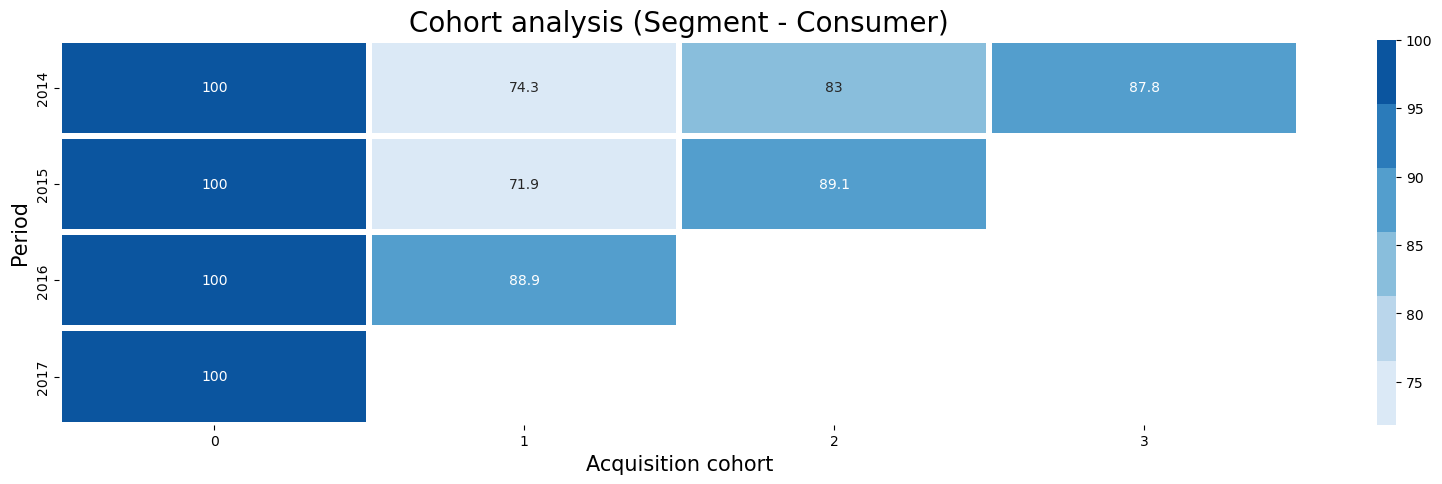

In [77]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_consumer, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Segment - Consumer)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

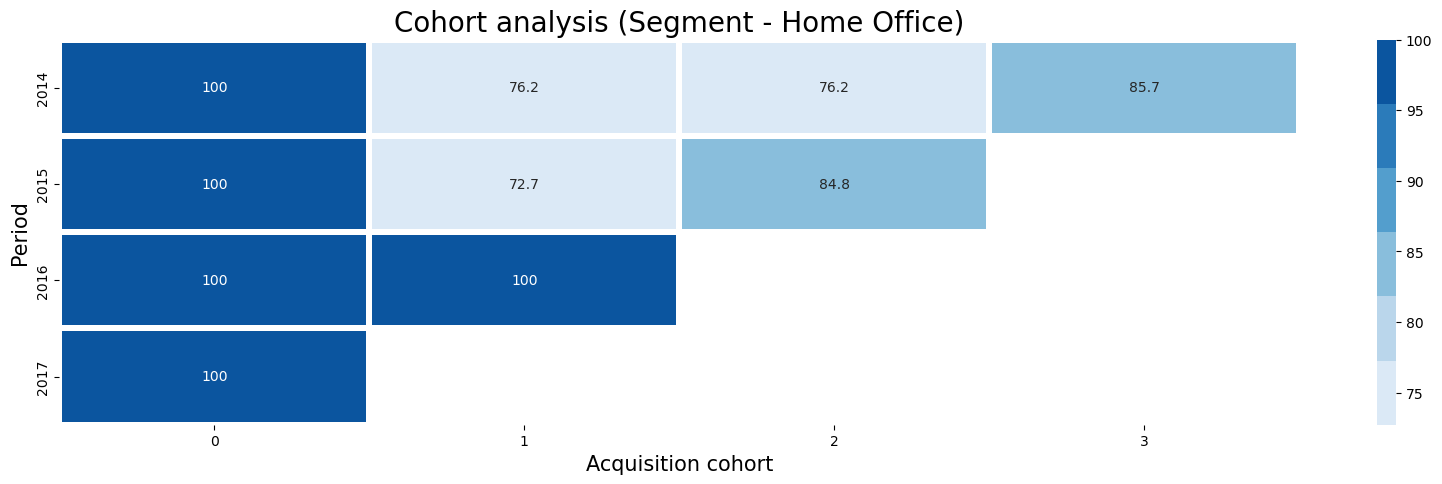

In [79]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_home, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Segment - Home Office)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

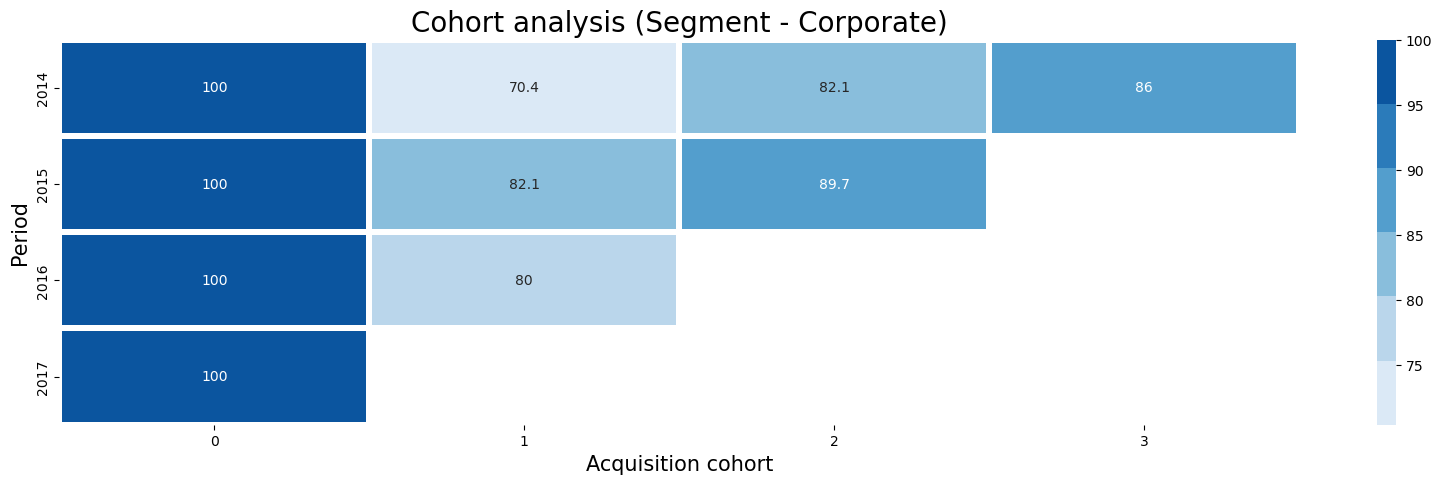

In [80]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_corporate, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Segment - Corporate)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

Видим, что в 2016 году, по сравнению с 2015 сегмент Consumer имеет схожие показатели, Home Office - лучшие, а Corporate, наоборот, худшие)

### Уникальные пользователи в разрезе ship_mode

In [86]:
df_standart = df.loc[df['ship_mode'] == 'Standard']
df_first = df.loc[df['ship_mode'] == 'First']
df_second = df.loc[df['ship_mode'] == 'Second']
df_same = df.loc[df['ship_mode'] == 'Same Day']

In [87]:
df_matrix_y_standart = get_cohort_matrix_2(df_standart, 'Y', percentage=True)
df_matrix_y_first = get_cohort_matrix_2(df_first, 'Y', percentage=True)
df_matrix_y_second = get_cohort_matrix_2(df_second, 'Y', percentage=True)
df_matrix_y_same = get_cohort_matrix_2(df_same, 'Y', percentage=True)

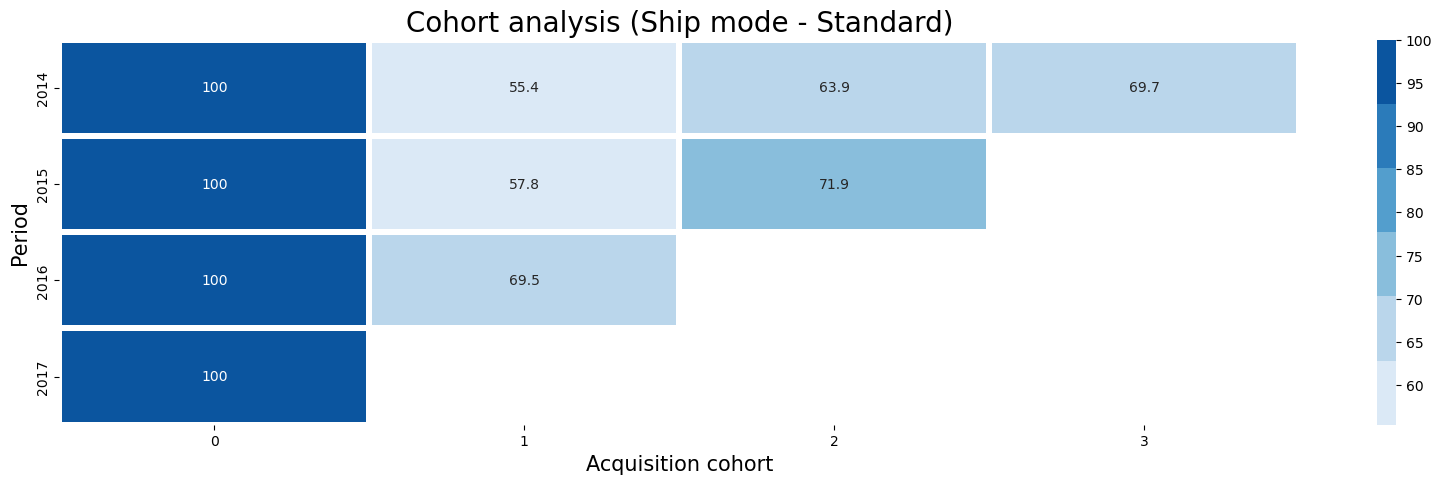

In [89]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_standart, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Ship mode - Standard)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

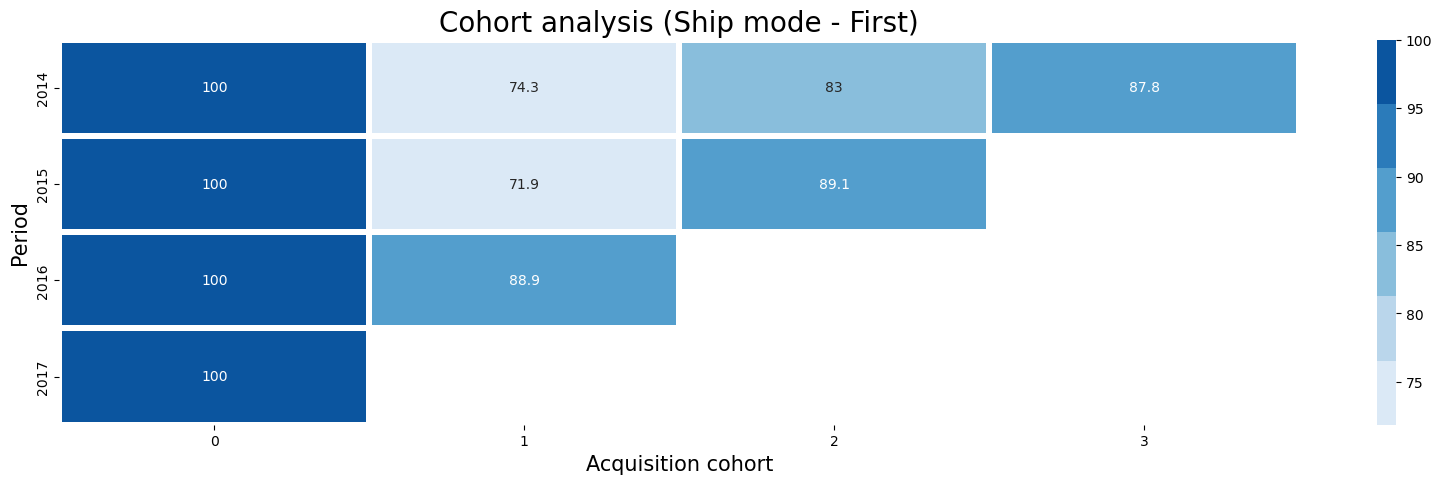

In [90]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_consumer, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Ship mode - First)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

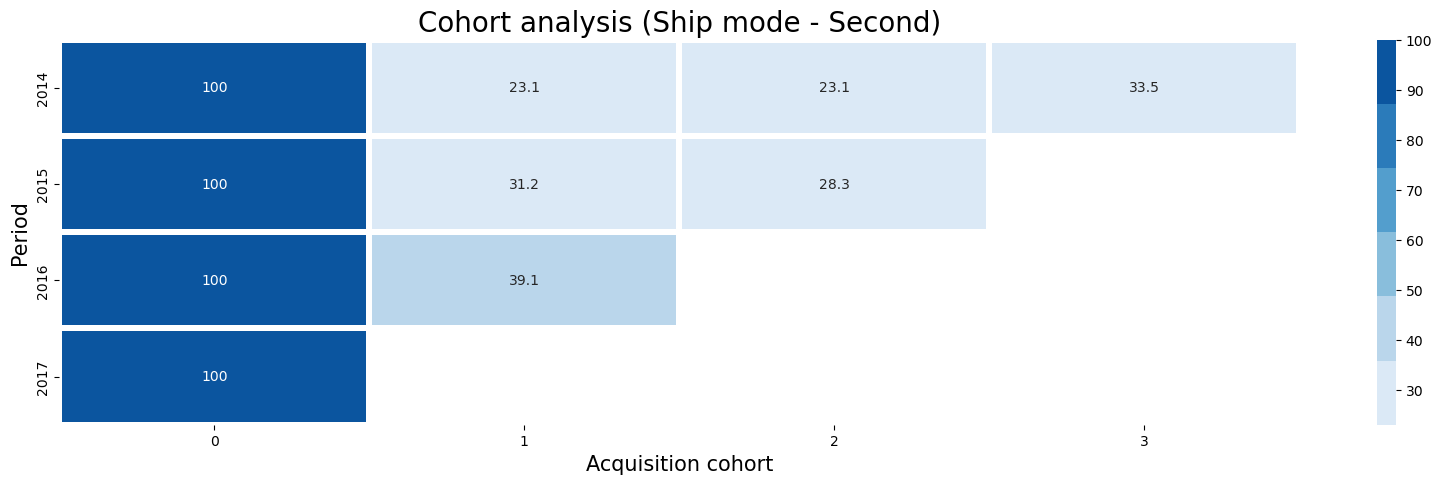

In [91]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_second, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Ship mode - Second)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

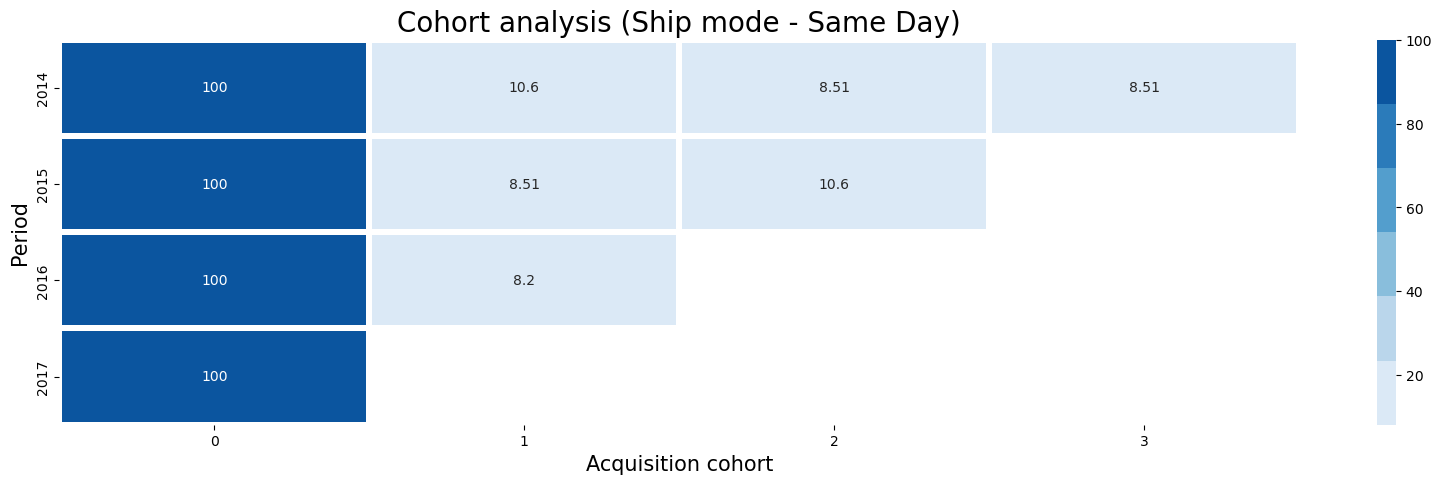

In [92]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_y_same, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis (Ship mode - Same Day)",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

Можно отметить резкое падение retention у группы Second и Same Day, но в сравнении у той же группы Second лучшие показатели в 2016 по сравнению с 2015.

### Бонус

Давайте дадим руководителю картину по уникальным пользователям в маленьких периодах - квартале и месяце

In [93]:
df_matrix_q_2 = get_cohort_matrix_2(df, 'Q', percentage=True)

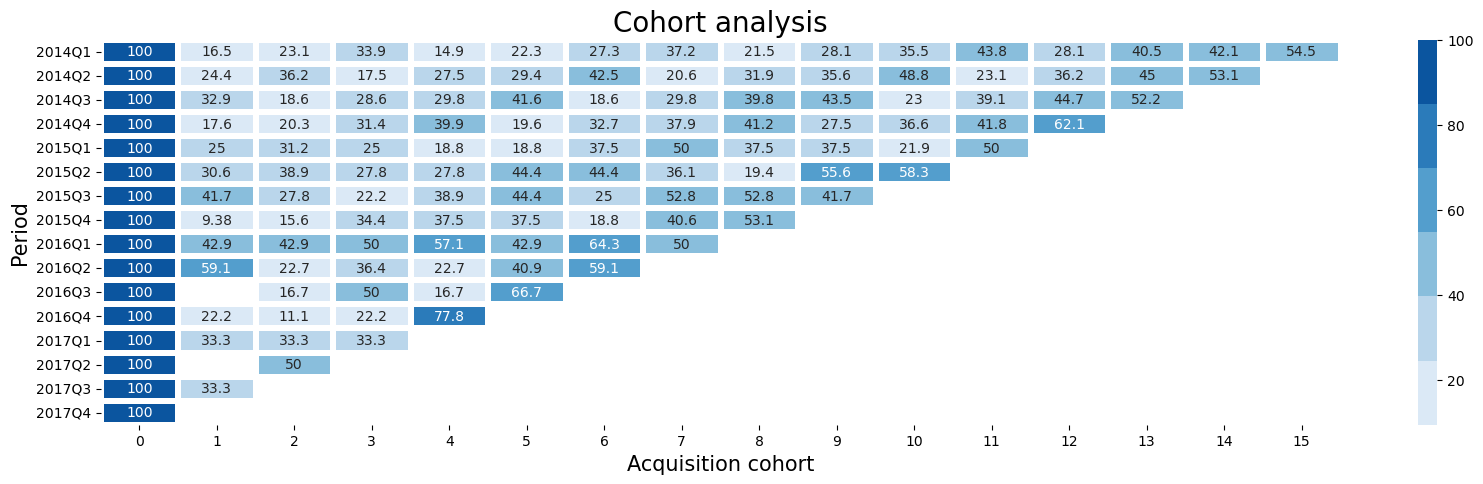

In [94]:
f, ax = plt.subplots(figsize=(20, 5))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_q_2, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

In [95]:
df_matrix_m_2 = get_cohort_matrix_2(df, 'M', percentage=True)

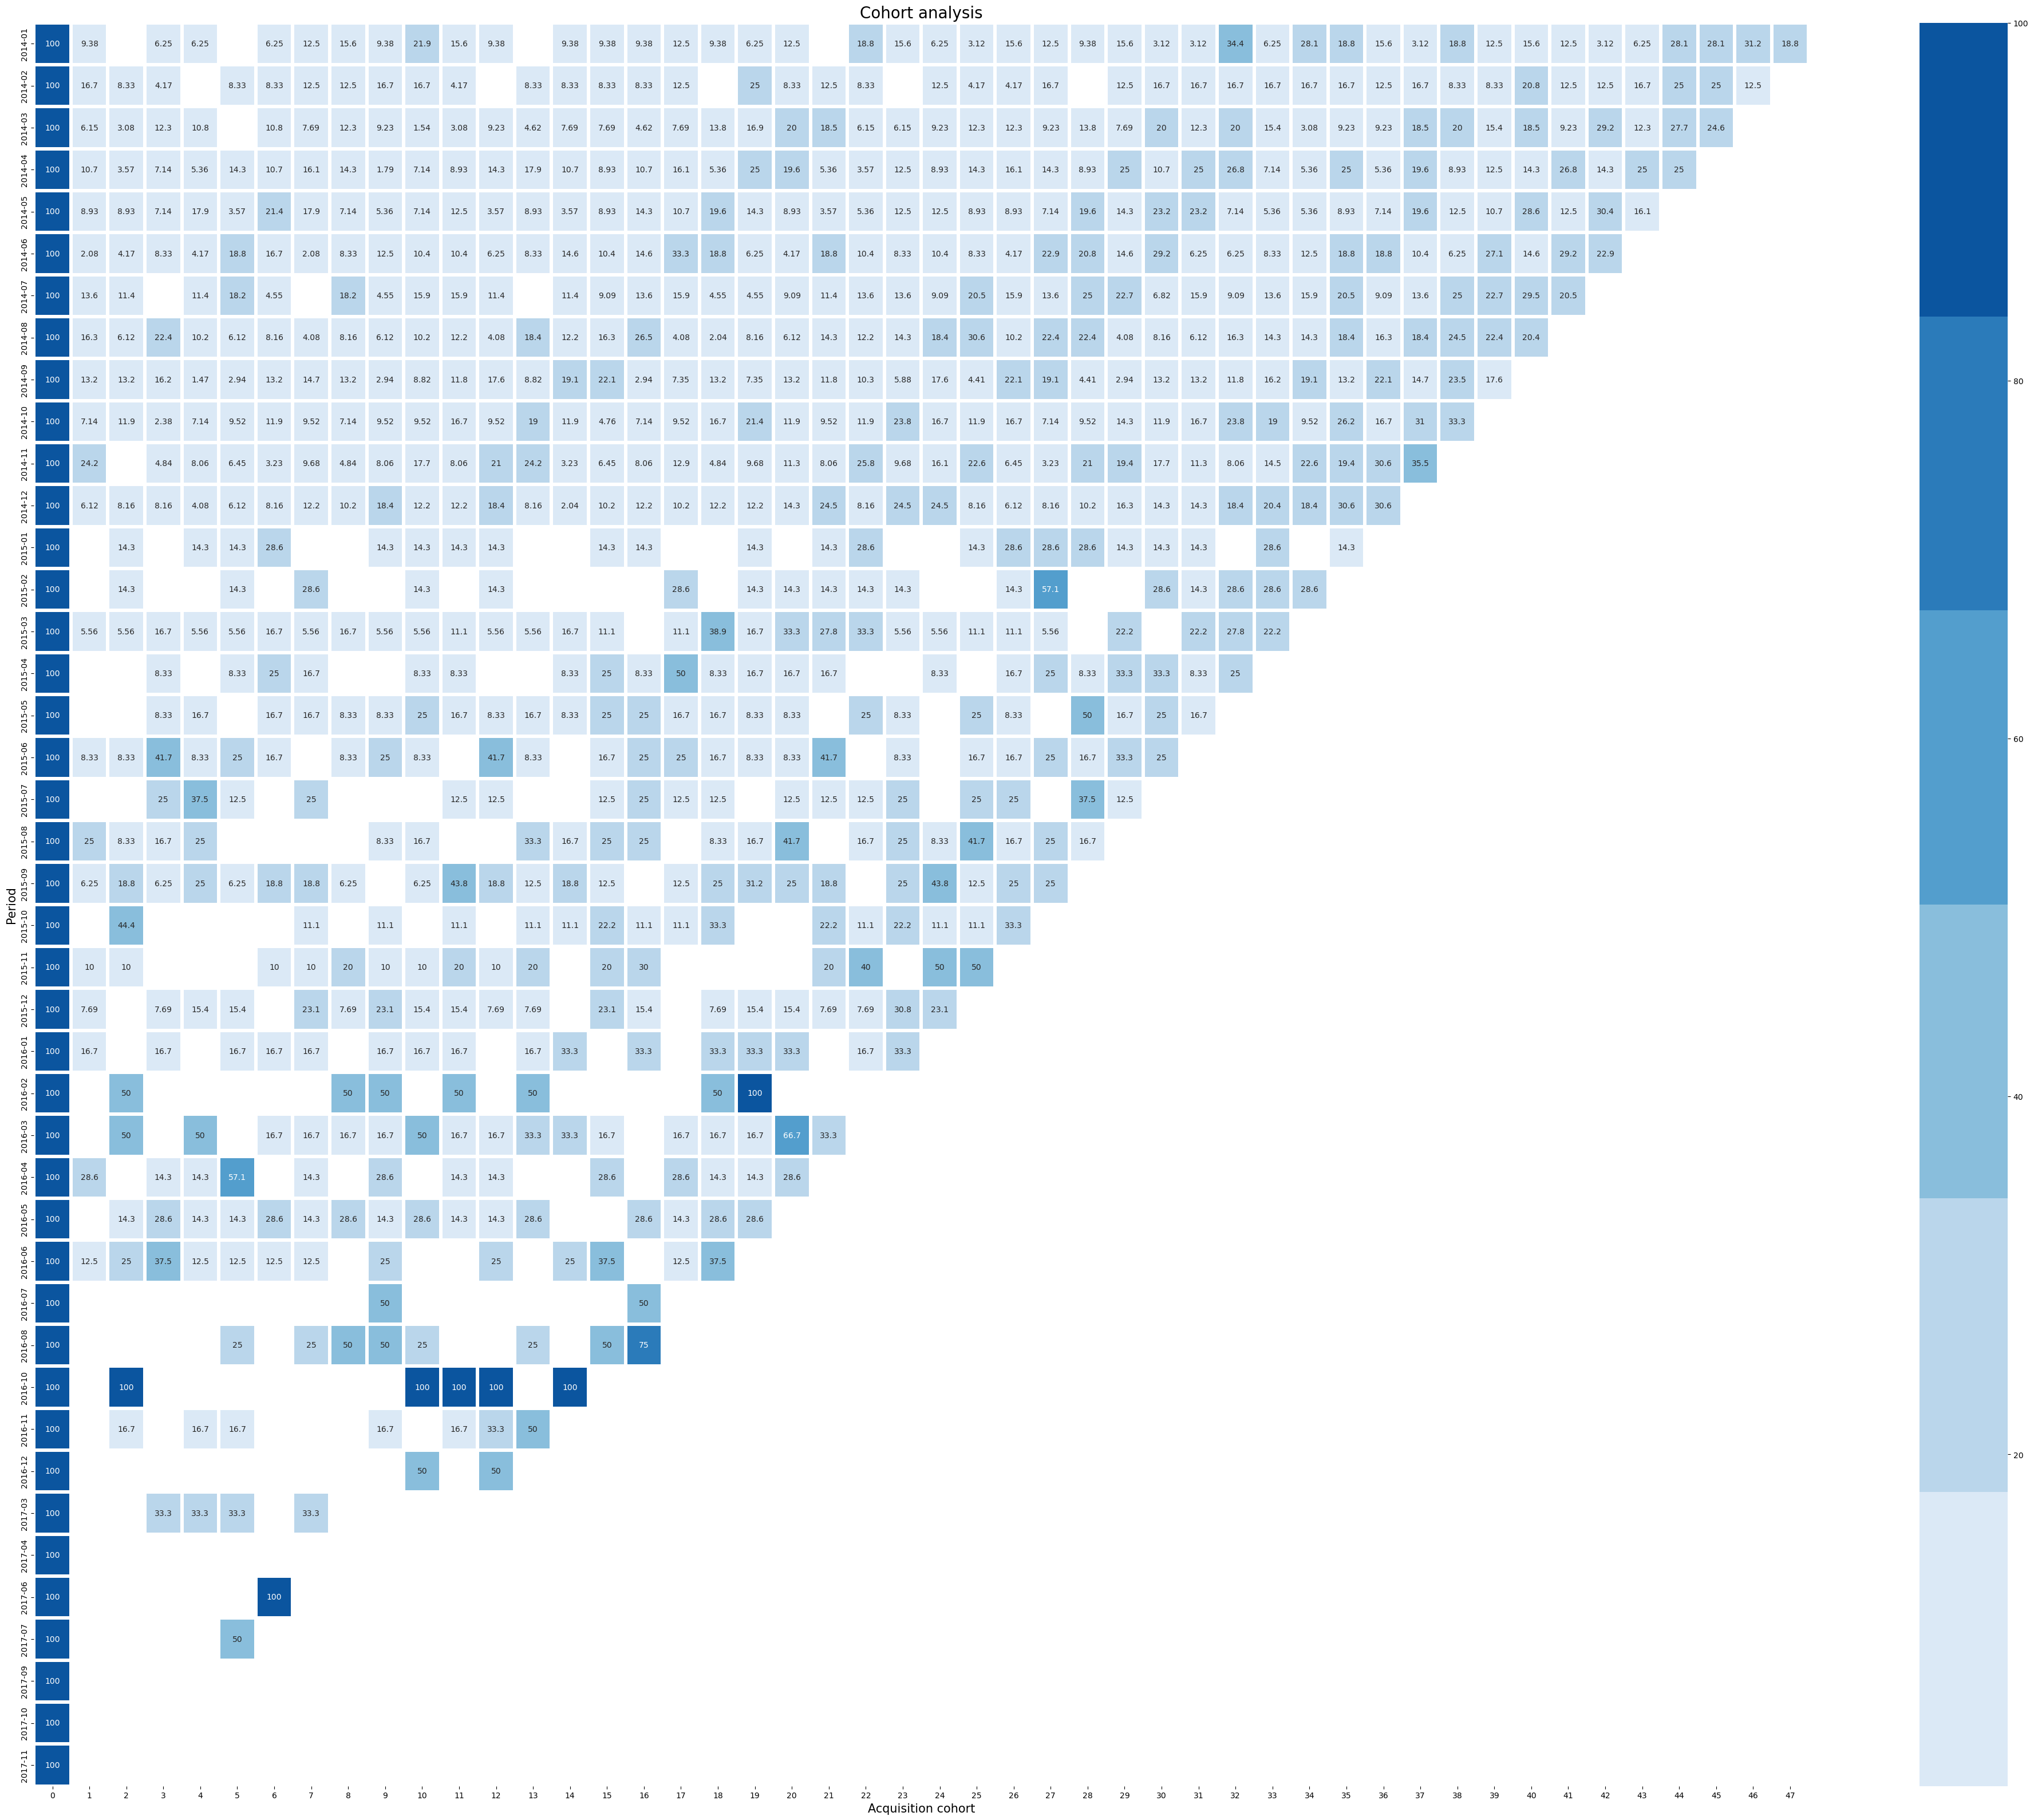

In [99]:
f, ax = plt.subplots(figsize=(50, 40))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_matrix_m_2, 
                    annot=True, 
                    linewidths=3, 
                    ax=ax, 
                    cmap=cmap,
                    fmt='.3g',
                    square=False)

ax.axes.set_title("Cohort analysis",fontsize=20)
ax.set_xlabel("Acquisition cohort",fontsize=15)
ax.set_ylabel("Period",fontsize=15)
plt.show()

Да, на месяце можно сломать глаза, но на кварталах можно попробовать поискать какие-либо сезонности. Например диагонали, соответстующие Q4 в 2014 и 2015 годах подозрительно просаживаются.